# Hyperparameter testing for ANN

We start by importing the necessary libraries and setting the random seed for reproducibility.

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping, Callback
from pytorch_lightning.loggers.csv_logs import CSVLogger


In [20]:
seed = 78 # random seed, used for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


We now download the dataset and prepare it before training

In [21]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),               # random crop for augmentation
    transforms.RandomHorizontalFlip(),                  # horizontal flip for augmentation
    transforms.ToTensor(),                              # convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),      # normalize by mean and std per channel
                         (0.2470, 0.2435, 0.2616))      #These values come from "https://github.com/kuangliu/pytorch-cifar/issues/19" where the values for normalization were computed
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


In [22]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=False,
    download=True,
    transform=transform_test
)

With both datasets separated, we can now create dataloaders for each dataset

In [23]:
from torch.utils.data import DataLoader, random_split

def get_loaders(train_dataset, test_dataset, batch_size):
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

Finally, we will use these loaders and datasets to train our ANN model.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class LitANN(pl.LightningModule):
    def __init__(self,
        input_size=32*32*3,
        hidden_sizes=[128, 64],
        num_classes=10,
        activation_fn=F.relu,
        learning_rate=0.001,
        optimizer_name='sgd',
        momentum=0.9,
        dropout_rate=0.0,
        use_batch_norm=False,
        weight_init=None
    ):
        super().__init__()
        self.save_hyperparameters()
        
        self.learning_rate = learning_rate
        self.activation_fn = activation_fn
        self.optimizer_name = optimizer_name.lower()
        self.momentum = momentum
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        
        # Build layers dynamically
        layers = []
        in_features = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            
            # Optional: Batch Normalization
            if self.use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            
            # Activation will be applied in forward()
            
            # Optional: Dropout
            if self.dropout_rate > 0:
                layers.append(nn.Dropout(self.dropout_rate))
            
            in_features = hidden_size
        
        self.hidden_layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(in_features, num_classes)
        
        # Apply weight initialization
        self._initialize_weights(weight_init)
    
    def _initialize_weights(self, method):
        """Initialize weights using specified strategy"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if method == 'xavier':
                    nn.init.xavier_uniform_(m.weight)
                elif method == 'he':
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif method == 'normal':
                    nn.init.normal_(m.weight, mean=0, std=0.01)
                
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation_fn(x)
            else:
                # BatchNorm or Dropout
                x = layer(x)
        
        x = self.output_layer(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', acc, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
    
    def configure_optimizers(self):
        """Configure optimizer based on optimizer_name"""
        if self.optimizer_name == 'sgd':
            return torch.optim.SGD(
                self.parameters(), 
                lr=self.learning_rate, 
                momentum=self.momentum
            )
        elif self.optimizer_name == 'adam':
            return torch.optim.Adam(
                self.parameters(), 
                lr=self.learning_rate
            )
        elif self.optimizer_name == 'rmsprop':
            return torch.optim.RMSprop(
                self.parameters(), 
                lr=self.learning_rate
            )
        else:
            raise ValueError(f"Unknown optimizer: {self.optimizer_name}")


In [25]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_SIZES = [ 128, 64]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | hidden_layers | ModuleList | 401 K  | train
1 | output_layer  | Linear     | 650    | train
-----------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 57.20it/s]         | Val Loss:   2.3014 | Val Acc:   0.1172


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 704/704 [00:46<00:00, 15.24it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 704/704 [00:46<00:00, 15.23it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 63.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4627000093460083
        test_loss           1.5202147960662842
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5202147960662842, 'test_acc': 0.4627000093460083}]

In [27]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the CSV file\ncsv_path = "logs/hs[128, 64]_optsgd_lr0.001/version_0/metrics.csv"\ndf = pd.read_csv(csv_path)\n\n# Extract test metrics (they appear only once at the end)\ntest_row = df[df[\'test_loss\'].notna()]\nif not test_row.empty:\n    test_loss = test_row[\'test_loss\'].values[0]\n    test_acc = test_row[\'test_acc\'].values[0]\n\n# Create the plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Loss plot\naxes[0].plot(df[\'epoch\'], df[\'train_loss_epoch\'], label=\'Train Loss\', marker=\'o\')\naxes[0].plot(df[\'epoch\'], df[\'val_loss\'], label=\'Val Loss\', marker=\'s\')\nif not test_row.empty:\n    axes[0].axhline(y=test_loss, color=\'r\', linestyle=\'--\', label=\'Test Loss\')\naxes[0].set_xlabel(\'Epoch\')\naxes[0].set_ylabel(\'Loss\')\naxes[0].set_title(\'Loss Over Epochs\')\naxes[0].legend()\naxes[0].grid(True)\n\n# Accuracy plot\naxes[1].plot(df[\'epoch\'], df[\'train_acc_epoch\'], label=\'Train Acc\'

# Hyperparameters:
* Number of layers and units 
* Activation functions (ReLU, Sigmoid, Tanh, others)
* Optimizers (SGD, Adam, RMSprop) 
* Learning rate  - A
* Batch size - A
* Number of epochs  - A
* Weight initialization strategies (e.g., Xavier, He) 
* Dropout rate - A
* Batch Normalization (with vs without) 


Due to the need of a starting point, we started by using the parameters declared on the following link: https://www.chalisebibek.com.np/image-classification-with-pytorch-lightning-simple-ann. However, as we can see, the results are insatisfactory, which means that the hyperparameters need to be optimized. The current hyperparameters are not able to capture the complexity of the data. 

As stated before, due to the need of optimizing hyperparameters, we decided to increase the number of layers and continuing to funnel the number of neurons to try and prevent overfitting

In [28]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        
# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | hidden_layers | ModuleList | 403 K  | train
1 | output_layer  | Linear     | 330    | train
-----------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 106.09it/s]         | Val Loss:   2.3017 | Val Acc:   0.1172


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 704/704 [00:26<00:00, 26.95it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 704/704 [00:26<00:00, 26.93it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 117.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4494999945163727
        test_loss            1.545510172843933
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.545510172843933, 'test_acc': 0.4494999945163727}]

In [29]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the CSV file\ncsv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"\ndf = pd.read_csv(csv_path)\n\n# Extract test metrics (they appear only once at the end)\ntest_row = df[df[\'test_loss\'].notna()]\nif not test_row.empty:\n    test_loss = test_row[\'test_loss\'].values[0]\n    test_acc = test_row[\'test_acc\'].values[0]\n\n# Create the plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Loss plot\naxes[0].plot(df[\'epoch\'], df[\'train_loss_epoch\'], label=\'Train Loss\', marker=\'o\')\naxes[0].plot(df[\'epoch\'], df[\'val_loss\'], label=\'Val Loss\', marker=\'s\')\nif not test_row.empty:\n    axes[0].axhline(y=test_loss, color=\'r\', linestyle=\'--\', label=\'Test Loss\')\naxes[0].set_xlabel(\'Epoch\')\naxes[0].set_ylabel(\'Loss\')\naxes[0].set_title(\'Loss Over Epochs\')\naxes[0].legend()\naxes[0].grid(True)\n\n# Accuracy plot\naxes[1].plot(df[\'epoch\'], df[\'train_acc_epoch\'], label=\'Train A

With the increase of the hidden layers, we can see that the accuracy and the loss both improved ever so slightly, without showing any signs of overfitting or underfitting. However, both metrics appear to be close to flatlining. So, in hopes of trying to discard the importance of the epochs, we tried to increase the number of epochs significantly and using early stopping with a min_delta of 0.005 to prevent overfitting. 


In [30]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | hidden_layers | ModuleList | 403 K  | train
1 | output_layer  | Linear     | 330    | train
-----------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 73: 100%|██████████| 704/704 [00:39<00:00, 17.75it/s, v_num=1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 99.84it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5300999879837036
        test_loss           1.3160182237625122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3160182237625122, 'test_acc': 0.5300999879837036}]

In [31]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the CSV file\ncsv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"\ndf = pd.read_csv(csv_path)\n\n# Extract test metrics (they appear only once at the end)\ntest_row = df[df[\'test_loss\'].notna()]\nif not test_row.empty:\n    test_loss = test_row[\'test_loss\'].values[0]\n    test_acc = test_row[\'test_acc\'].values[0]\n\n# Create the plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Loss plot\naxes[0].plot(df[\'epoch\'], df[\'train_loss_epoch\'], label=\'Train Loss\', marker=\'o\')\naxes[0].plot(df[\'epoch\'], df[\'val_loss\'], label=\'Val Loss\', marker=\'s\')\nif not test_row.empty:\n    axes[0].axhline(y=test_loss, color=\'r\', linestyle=\'--\', label=\'Test Loss\')\naxes[0].set_xlabel(\'Epoch\')\naxes[0].set_ylabel(\'Loss\')\naxes[0].set_title(\'Loss Over Epochs\')\naxes[0].legend()\naxes[0].grid(True)\n\n# Accuracy plot\naxes[1].plot(df[\'epoch\'], df[\'train_acc_epoch\'], label=\'Train A

As we can see, there was a slight increase on performance on both the accuracy and the loss, but even though the number of epochs was set to 100, the training was stopped by the early stopping method, meaning it didn't improve enough to keep training. So, from now on, the number of epochs will always be 100 with early stopping of min_delta = 0.005

Since the early testing showed that increasing the number of hidden layers improved the performance, we decided to add one more hidden layer and test the result

In [32]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32, 16]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | hidden_layers | ModuleList | 404 K  | train
1 | output_layer  | Linear     | 170    | train
-----------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.618     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 35: 100%|██████████| 704/704 [00:40<00:00, 17.40it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 84.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5095000267028809
        test_loss           1.3945926427841187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3945926427841187, 'test_acc': 0.5095000267028809}]

In [33]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the CSV file\ncsv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"\ndf = pd.read_csv(csv_path)\n\n# Extract test metrics (they appear only once at the end)\ntest_row = df[df[\'test_loss\'].notna()]\nif not test_row.empty:\n    test_loss = test_row[\'test_loss\'].values[0]\n    test_acc = test_row[\'test_acc\'].values[0]\n\n# Create the plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Loss plot\naxes[0].plot(df[\'epoch\'], df[\'train_loss_epoch\'], label=\'Train Loss\', marker=\'o\')\naxes[0].plot(df[\'epoch\'], df[\'val_loss\'], label=\'Val Loss\', marker=\'s\')\nif not test_row.empty:\n    axes[0].axhline(y=test_loss, color=\'r\', linestyle=\'--\', label=\'Test Loss\')\naxes[0].set_xlabel(\'Epoch\')\naxes[0].set_ylabel(\'Loss\')\naxes[0].set_title(\'Loss Over Epochs\')\naxes[0].legend()\naxes[0].grid(True)\n\n# Accuracy plot\naxes[1].plot(df[\'epoch\'], df[\'train_acc_epoch\'], label=\'Train A

As we can see, the increasing of the number of hidden layers (with funneling ) didn't provide any significant improve in accuracy and actually a worst value for loss. For that reason, we decided to go back to the last layout (without the last layer)


Next, we decided to test different activation functions, to see which one is better for the task at hands. We will start with the leaky relu

In [34]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.leaky_relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | hidden_layers | ModuleList | 403 K  | train
1 | output_layer  | Linear     | 330    | train
-----------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 29: 100%|██████████| 704/704 [00:34<00:00, 20.54it/s, v_num=2]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 98.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5008999705314636
        test_loss           1.4100968837738037
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.4100968837738037, 'test_acc': 0.5008999705314636}]

In [35]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the CSV file\ncsv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"\ndf = pd.read_csv(csv_path)\n\n# Extract test metrics (they appear only once at the end)\ntest_row = df[df[\'test_loss\'].notna()]\nif not test_row.empty:\n    test_loss = test_row[\'test_loss\'].values[0]\n    test_acc = test_row[\'test_acc\'].values[0]\n\n# Create the plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Loss plot\naxes[0].plot(df[\'epoch\'], df[\'train_loss_epoch\'], label=\'Train Loss\', marker=\'o\')\naxes[0].plot(df[\'epoch\'], df[\'val_loss\'], label=\'Val Loss\', marker=\'s\')\nif not test_row.empty:\n    axes[0].axhline(y=test_loss, color=\'r\', linestyle=\'--\', label=\'Test Loss\')\naxes[0].set_xlabel(\'Epoch\')\naxes[0].set_ylabel(\'Loss\')\naxes[0].set_title(\'Loss Over Epochs\')\naxes[0].legend()\naxes[0].grid(True)\n\n# Accuracy plot\naxes[1].plot(df[\'epoch\'], df[\'train_acc_epoch\'], label=\'Train A

As we can see, changing the activation function to a leaky_relu, improved the accuracy, the loss and allowed the network to learn for a few more epochs. we will try with a different activation function.


In [36]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.elu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | hidden_layers | ModuleList | 403 K  | train
1 | output_layer  | Linear     | 330    | train
-----------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 37: 100%|██████████| 704/704 [00:26<00:00, 26.90it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 139.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5180000066757202
        test_loss           1.3671553134918213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3671553134918213, 'test_acc': 0.5180000066757202}]

In [37]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the CSV file\ncsv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"\ndf = pd.read_csv(csv_path)\n\n# Extract test metrics (they appear only once at the end)\ntest_row = df[df[\'test_loss\'].notna()]\nif not test_row.empty:\n    test_loss = test_row[\'test_loss\'].values[0]\n    test_acc = test_row[\'test_acc\'].values[0]\n\n# Create the plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Loss plot\naxes[0].plot(df[\'epoch\'], df[\'train_loss_epoch\'], label=\'Train Loss\', marker=\'o\')\naxes[0].plot(df[\'epoch\'], df[\'val_loss\'], label=\'Val Loss\', marker=\'s\')\nif not test_row.empty:\n    axes[0].axhline(y=test_loss, color=\'r\', linestyle=\'--\', label=\'Test Loss\')\naxes[0].set_xlabel(\'Epoch\')\naxes[0].set_ylabel(\'Loss\')\naxes[0].set_title(\'Loss Over Epochs\')\naxes[0].legend()\naxes[0].grid(True)\n\n# Accuracy plot\naxes[1].plot(df[\'epoch\'], df[\'train_acc_epoch\'], label=\'Train A

so far, this hasn't been better than the leaky relu, we will try with a different one

In [38]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.tanh  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | hidden_layers | ModuleList | 403 K  | train
1 | output_layer  | Linear     | 330    | train
-----------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 68: 100%|██████████| 704/704 [00:41<00:00, 17.17it/s, v_num=4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 97.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3889999985694885
        test_loss           1.8465255498886108
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.8465255498886108, 'test_acc': 0.3889999985694885}]

In [39]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the CSV file\ncsv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"\ndf = pd.read_csv(csv_path)\n\n# Extract test metrics (they appear only once at the end)\ntest_row = df[df[\'test_loss\'].notna()]\nif not test_row.empty:\n    test_loss = test_row[\'test_loss\'].values[0]\n    test_acc = test_row[\'test_acc\'].values[0]\n\n# Create the plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Loss plot\naxes[0].plot(df[\'epoch\'], df[\'train_loss_epoch\'], label=\'Train Loss\', marker=\'o\')\naxes[0].plot(df[\'epoch\'], df[\'val_loss\'], label=\'Val Loss\', marker=\'s\')\nif not test_row.empty:\n    axes[0].axhline(y=test_loss, color=\'r\', linestyle=\'--\', label=\'Test Loss\')\naxes[0].set_xlabel(\'Epoch\')\naxes[0].set_ylabel(\'Loss\')\naxes[0].set_title(\'Loss Over Epochs\')\naxes[0].legend()\naxes[0].grid(True)\n\n# Accuracy plot\naxes[1].plot(df[\'epoch\'], df[\'train_acc_epoch\'], label=\'Train A

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.sigmoid  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

AttributeError: module 'torch.nn.functional' has no attribute 'Sigmoid'

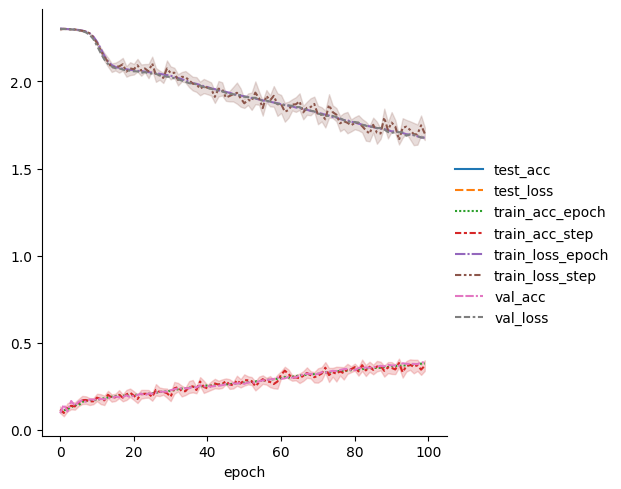

In [ ]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

as we can see, we weren't able to find any activation function that was better than the leaky relu. Looking at the graph, we can clearly see that both the values of the accuracy and the loss are way worst than previous attempts. We can also see that it was getting better over the epochs but it reached the previously established epoch limit. Our theory is that, with enough epochs, it would reach around the same values as the other functions, and then starting to flatline

# ///////////////////////////////////////////////////

# Learning Rate

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 1
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.5
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.1
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.05
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.05
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "logs/hs[128, 64, 32]_optsgd_lr0.001/version_0/metrics.csv"
df = pd.read_csv(csv_path)

# Extract test metrics (they appear only once at the end)
test_row = df[df['test_loss'].notna()]
if not test_row.empty:
    test_loss = test_row['test_loss'].values[0]
    test_acc = test_row['test_acc'].values[0]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss', marker='o')
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='s')
if not test_row.empty:
    axes[0].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(df['epoch'], df['train_acc_epoch'], label='Train Acc', marker='o')
axes[1].plot(df['epoch'], df['val_acc'], label='Val Acc', marker='s')
if not test_row.empty:
    axes[1].axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print test results
if not test_row.empty:
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
"""

# Batch Size

In [ ]:
# Hyperparameters to test
BATCH_SIZE = 16
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
# Hyperparameters to test
BATCH_SIZE = 32
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
# Hyperparameters to test
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
# Hyperparameters to test
BATCH_SIZE = 128
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
# Hyperparameters to test
BATCH_SIZE = 256
EPOCHS = 100
HIDDEN_SIZES = [ 128, 64, 32]
ACTIVATION_FN = F.relu  # or F.leaky_relu, torch.sigmoid, torch.tanh
LEARNING_RATE = 0.001
OPTIMIZER = 'sgd'  # 'sgd', 'adam', 'rmsprop'
DROPOUT_RATE = 0.0
USE_BATCH_NORM = False
WEIGHT_INIT = None
MOMENTUM = 0.9  # 'xavier', 'he', 'normal'

# Get data loaders
train_loader, val_loader, test_loader = get_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

# Create model
model = LitANN(
    hidden_sizes=HIDDEN_SIZES,
    activation_fn=ACTIVATION_FN,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    use_batch_norm=USE_BATCH_NORM,
    weight_init=WEIGHT_INIT,
    momentum=MOMENTUM
)

csv_logger = CSVLogger(
    "logs", 
    name=f"hs{HIDDEN_SIZES}_opt{OPTIMIZER}_lr{LEARNING_RATE}"
)

# Setup callbacks and logger
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

class EpochProgressCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        train_loss = metrics.get('train_loss_epoch', metrics.get('train_loss', 0))
        train_acc = metrics.get('train_acc_epoch', metrics.get('train_acc', 0))
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_acc = metrics.get('val_acc', 0)
        print(f"         | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Train
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback, EpochProgressCallback()],
    logger=csv_logger, enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)